# Sniffing 2.4 GHz Keyboard Traffic

In [9]:
import jsonlines
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import numpy as np
import scipy.stats as stats


## Data Loading

In [2]:
data_dir = Path.cwd() / Path('data')
wpms = list(range(20, 80, 10))
data = {}
for wpm in wpms:
    data_path = data_dir / Path(f'{wpm}.jsonl')
    with jsonlines.open(data_path) as rdr:
        curr_data = list(rdr.iter())
        data[wpm] = curr_data

In [3]:
valid_mac = "cd:04:03:02:01"
invalid_cnt = {}
for wpm in data:
    invalid_cnt[wpm] = len(list(filter(lambda x: x['mac'] != valid_mac, data[wpm])))
    data[wpm] = list(filter(lambda x: x['mac'] == valid_mac, data[wpm]))

channels = {}
times = {}
for wpm, cdata in data.items():
    channels[wpm] = list(map(lambda x: x['channel'], cdata))
    times[wpm] = list(map(lambda x: x['time'] / 1000, cdata))

## Time to sniff vs WPM

In [4]:
for wpm in wpms:
    tot_hits = invalid_cnt[wpm] + len(data[wpm])
    invalid_percent = invalid_cnt[wpm] / tot_hits * 100
    mean = np.mean(times[wpm])
    std = np.std(times[wpm])
    median = np.median(times[wpm])
    print(f"WPM = {wpm}")
    print(f"\tMean = {mean:.2f} s, Std Dev = {std:.2f} s, Median = {median:.2f} s")
    print(f"\tHits = {tot_hits}, Spurious hits = {invalid_percent:.2f}%")

WPM = 20
	Mean = 194.37 s, Std Dev = 106.14 s, Median = 165.56 s
	Hits = 19, Spurious hits = 31.58%
WPM = 30
	Mean = 88.66 s, Std Dev = 69.98 s, Median = 72.54 s
	Hits = 16, Spurious hits = 25.00%
WPM = 40
	Mean = 74.01 s, Std Dev = 76.46 s, Median = 53.14 s
	Hits = 24, Spurious hits = 12.50%
WPM = 50
	Mean = 53.14 s, Std Dev = 38.95 s, Median = 52.99 s
	Hits = 34, Spurious hits = 8.82%
WPM = 60
	Mean = 50.60 s, Std Dev = 53.54 s, Median = 39.81 s
	Hits = 36, Spurious hits = 11.11%
WPM = 70
	Mean = 31.38 s, Std Dev = 35.47 s, Median = 23.12 s
	Hits = 55, Spurious hits = 7.27%


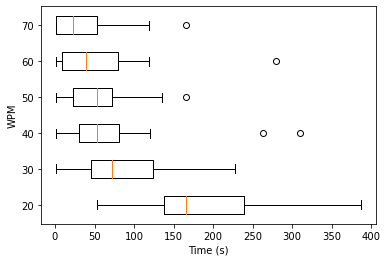

In [5]:
fig, ax = plt.subplots()
times_vec = [times[wpm] for wpm in wpms]
ax.boxplot(times_vec, positions=wpms, vert=False, widths=5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('WPM')
plt.show()

## Channel we are detecting on

In [6]:
chan_counts = {}
for wpm in wpms:
    for chan in channels[wpm]:
       chan_counts[chan] = chan_counts.get(chan, 0) + 1 

print('Actual channel = 34')
print('\nChannel | Count')
print('--------+------')
chans = sorted(chan_counts.keys())
for chan in chans:
    print(f'{chan:2d}      | {chan_counts[chan]:3d}')
print('--------+------')

Actual channel = 34

Channel | Count
--------+------
34      |  17
35      |  76
38      |  51
39      |  16
--------+------


Mean = 36.25
Std = 1.7356554957709782


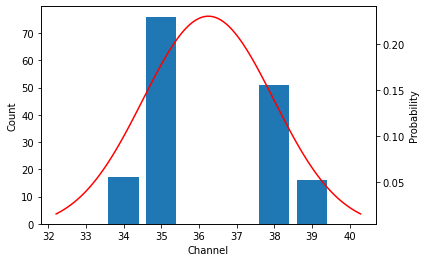

In [17]:
expanded_chans = []
for chan in chans:
    expanded_chans.extend([chan] * chan_counts[chan])
chan_mean = np.mean(expanded_chans)
chan_std = np.std(expanded_chans)

print(f'Mean = {chan_mean}')
print(f'Std = {chan_std}')

distr = stats.norm(chan_mean, chan_std)

std_x = np.linspace(distr.ppf(0.01), distr.ppf(0.99), 100)
std_y = distr.pdf(std_x)

fig, ax = plt.subplots()
counts = [chan_counts[chan] for chan in chans]
ax.bar(chans, counts)
ax2 = ax.twinx()
ax2.plot(std_x, std_y, color='red')
ax2.set_ylabel('Probability')
ax.set_xlabel('Channel')
ax.set_ylabel('Count')
plt.show()